<a href="https://colab.research.google.com/github/ElenaSelishcheva/ML_course_7_semester/blob/main/Homework_%E2%84%963.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задачи по классификации с использованием персептрона

1. **Определить минимальное число прямых, требуемое для отделения точек одного класса от другого.**

2. **Определить число связных выпуклых областей, на которые разделён каждый из указанных классов.**

3. **Исходя из полученных результатов, оценить минимальное число слоёв и нейронов в каждом слое, достаточное для успешной классификации.**

4. **Рассчитать значения коэффициентов сети, считая функцию активации ступенчатой.**

5. **Проверить свои выводы, сгенерировав выборку и подав её на персептрон.**  
   При этом требуется получить значения не только выходного слоя, но и скрытых слоёв. Поменять функцию активации, пронаблюдать изменения результатов.

6. **Попытаться получить значения коэффициентов путём обучения, сравнить получаемые результаты с итогами предыдущего пункта.**  
   Выявить различия, если они имеются.

7. **Оценить влияние числа нейронов на качество результатов.**  
   Для этого попробовать обучить сети с числом нейронов в скрытых слоях на единицу меньше или больше ранее рассчитанного и вычислить параметры точности (precision и recall) классификации в зависимости от числа нейронов.





### Мой вариант: первый класс - точки внутри квадрата, второй - вне него

1. **Минимальное число прямых - 4**

2. **Число связных выпуклых областей - 5**

3. **Минимальное число слоёв - 3  
Нейронов в каждом слое: 4 - в первом слое, 5 - во втором и 2 - в третьем**



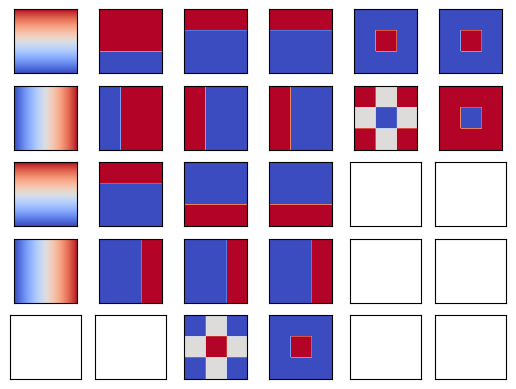

In [ ]:
import math

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

# В задании 2 работы 3 требуется определить число нейронов, требуемое
# для решения задачи классификации точек двумерного пространства.
# Чтобы проверить выводы, можно реализовать маленький персептрон
# с явно задаваемыми синаптическими коэффициентами,
# чтобы получить доступ ко всем выходам его нейронов. Сделаем это
# для задачи классификации, рассмотренной на лекции по нейросетям

def logistic(x, s=10):
    # логистическая функция активации
    return 1 / (1 + np.exp(-s*x))

def sign(x):
    # пороговая функция активации
    return (x > 0) * 1.

def relu(x):
    # ReLU-функция активации
    return x if x > 0 else 0.

class ManualMLP:
    # чтобы не лезть в детали реализации многослойного персептрона
    # в scikit-learn, сделаем свой маленький класс для него (без метода обучения,
    # т.е. только с ручным заданием коэффициентов)
    def __init__(self, coeffs, intercepts, act_func):
        # создать сеть по списку коэффициентов и функции активации
        self.coeffs = coeffs  # синаптические коэффициенты при входах
        self.intercepts = intercepts  # коэффициенты - постоянные (смещения нуля)
        self.act_func = act_func  # функция активации

    def predict(self, X):
        # получить выходы всех слоёв, а не только последнего
        curr_val = X
        results = []
        for i in range(len(self.coeffs)):
            # для каждого слоя провести линейное преобразование предыдущего
            curr_val = np.matmul(curr_val, self.coeffs[i]) + self.intercepts[i]
            # поместить его выход в результаты
            results.append(curr_val)
            # применить к этому же выходу нелинейное преобразование
            curr_val2 = self.act_func(curr_val)
            # поместить его тоже в результаты
            curr_val = curr_val2
            results.append(curr_val2)
        # выдать из функции и выход, и список результатов каждого слоя
        return curr_val, results

# создадим массивы коэффициентов, которые были в явном виде рассчитаны
# на лекции для задачи классификации
layer1_c = [[0, 1, 0, 1],
            [1, 0, 1, 0]]
layer1_i = [-3, -3, -6, -6]

layer2_c = [[0, 0, -1, 0, 1],
            [0, -1, 0, 0, 1],
            [1, 0, 0, 0, -1],
            [0, 0, 0, 1, -1]]
layer2_i = [-0.5, 0.5, 0.5, -0.5, -1.5]

layer3_c = [[0, 1],
            [0, 1],
            [0, 1],
            [0, 1],
            [1, 0]]
layer3_i = [-0.5, -0.5]

# создадим сеть с этими коэффициентами и пороговыми функциями активации всех слоёв
mlp = ManualMLP([np.array(layer1_c), np.array(layer2_c), np.array(layer3_c)],
                [np.array(layer1_i), np.array(layer2_i), np.array(layer3_i)],
                sign)

mlp_log = ManualMLP([np.array(layer1_c), np.array(layer2_c), np.array(layer3_c)],
                [np.array(layer1_i), np.array(layer2_i), np.array(layer3_i)],
                logistic)

# обучать сеть не надо, потому что коэффициенты для неё мы рассчитали вручную;
# можно просто вывести её результаты для рассматриваемой области данных

def draw_all_layers_output(net, min_x, max_x, min_y, max_y, dx, dy):
    # функция вывода результатов работы всех нейронов сети net;
    # принимает она два числа -первое принимает значения
    # от min_x до max_x с шагом dx, второе - от min_y до max_y с шагом dy
    # Вычислим размер входных данных
    nx = round((max_x - min_x) / dx) + 1
    ny = round((max_y - min_y) / dy) + 1
    # составим из них решётку - пару матриц vx,vy, в которых
    # сочетаются все возможные пары x и y
    px = np.linspace(min_x, max_x, nx)
    py = np.linspace(min_x, max_x, ny)
    vx, vy = np.meshgrid(px, py)
    test_set = np.vstack([np.ravel(vx), np.ravel(vy)]).T
    # предскажем классы всех элементов решётки на нейросети
    preds,interm = net.predict(test_set)

    # выведем эти классы
    fig, axs = plt.subplots(nrows=5, ncols=6)
    # размеры слоёв сети
    szs = [interm[i].shape[1] for i in range(len(interm))]

    for i,sz in enumerate(szs):
        for j in range(sz):
            # для каждого используемого нейрона вывести выход в виде изображения
            reshaped_data = np.reshape(interm[i][:,j], (nx, ny))
            dt = np.flip(reshaped_data, 0)
            axs[j, i].imshow(dt, cmap=cm.coolwarm)
            axs[j, i].set_xticks([])
            axs[j, i].set_yticks([])
            # неиспользуемыми оставить пустыми
            for j in range(sz, max(szs)):
                axs[j, i].set_xticks([])
                axs[j, i].set_yticks([])
    plt.show()

# выведем выходы всех нейронов сети mlp в диапазонах x и y [-3,10]
# с шагом x и y 0.1. Слои выводятся слева направо; для каждого нейрона
# выводится сначала сумма входов, а потом результат действия функции активации
# на эту сумму.

draw_all_layers_output(mlp, 0, 9, 0, 9, 0.1, 0.1)

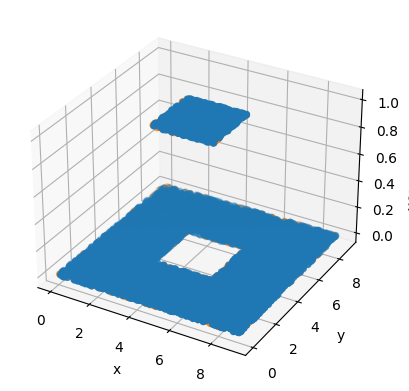

Network with l1=1 processed in experiment 1
Network with l1=2 processed in experiment 1
Network with l1=3 processed in experiment 1
Network with l1=4 processed in experiment 1
Network with l1=5 processed in experiment 1
Network with l1=6 processed in experiment 1
Network with l1=7 processed in experiment 1
Network with l1=1 processed in experiment 2
Network with l1=2 processed in experiment 2
Network with l1=3 processed in experiment 2
Network with l1=4 processed in experiment 2
Network with l1=5 processed in experiment 2
Network with l1=6 processed in experiment 2
Network with l1=7 processed in experiment 2
Network with l1=1 processed in experiment 3
Network with l1=2 processed in experiment 3
Network with l1=3 processed in experiment 3
Network with l1=4 processed in experiment 3
Network with l1=5 processed in experiment 3
Network with l1=6 processed in experiment 3
Network with l1=7 processed in experiment 3
Precisions: [0.         0.         0.         0.         0.33333333 0.
 0.64

In [ ]:
import warnings
warnings.filterwarnings("ignore")

N = 10000
# x и y равномерно покрывают плоскость
xs = np.random.uniform(0,9,size=(N,1))
ys = np.random.uniform(0,9,size=(N,1))
# выделим классы по той же логике, что в лекции
line1 = ys - 3 > 0 # N11
line2 = xs - 3 > 0 # N12
line3 = ys - 6 > 0 # N13
line4 = xs - 6 > 0 # N14
# выпуклые области получим сочетанием линейных разбиений, как в лекции
area1 = np.logical_and(np.logical_and(line1, line2), np.logical_not(np.logical_or(line3, line4)))
# так как классов всего два, достаточно выделить один из них
class_ids = 1 * area1

# выборка будет состоять из точек points и номеров их классов class_ids
points = np.hstack((xs,ys))

# разделим единую начальную выборку на обучающую и тестовую.
# Классификатор будет обучаться только на первой из них, а качество
# работы будет оцениваться по второй. Это нужно для распознавания переобучения:
# если классификатор намного лучше сработает на обучающей выборке,
# чем на тестовой, он слишком приспособился к конкретным примерам
# и потерял способность обобщать данные.

points_train, points_test, classes_train, classes_test = train_test_split(points, class_ids,
                                                                          train_size=0.8,
                                                                          random_state=17,
                                                                          shuffle=True)

# нарисуем обучающую и тестовую выборки
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points_train[:,0], points_train[:,1], classes_train, 'b')
ax.scatter(points_test[:,0], points_test[:,1], classes_test, 'r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('номер класса')
plt.show()

# проверяемые размеры слоёв
layer1_sizes = [1, 2, 3, 4, 5, 6, 7]


# массивы для результатов
precisions = np.zeros((len(layer1_sizes)))
recalls = np.zeros((len(layer1_sizes)))

# число повторов проверок (т.е. число обучаемых нейросетей каждой конфигурации)
NE = 3

for e_num in range(NE):
    for i, layer1_size in enumerate(layer1_sizes):
      # сделаем сеть с числом нейронов скрытых слоёв,
      # равным (layer1_size). Так как
      # функция активация будет отличаться от sign, результат вполне может
      # быть другим. Можно проверить его, заменив 'logistic' на 'relu' или 'tanh'
      mlp = MLPClassifier(hidden_layer_sizes=(layer1_size),
                          activation='logistic',)
      # обучаем классификатор на обучающей выборке
      mlp.fit(points_train,np.ravel(classes_train))
      # предсказываем классы для тестовой выборки
      classes_predicted = mlp.predict(points_test)
      # вырабатываем оценку качества
      rep = classification_report(classes_test, classes_predicted,output_dict=True)
      # выберем из результатов precision и recall для класса 1
      precisions[i] += rep['1']['precision']
      recalls[i] += rep['1']['recall']
      print(f'Network with l1={layer1_size} processed in experiment {e_num+1}')

# усредняем собранные данные
precisions /= NE
recalls /= NE
# выводим их в явном виде на всякий случай
print("Precisions:", precisions)
print("Recalls:", recalls)

### Визуализация precision и recall

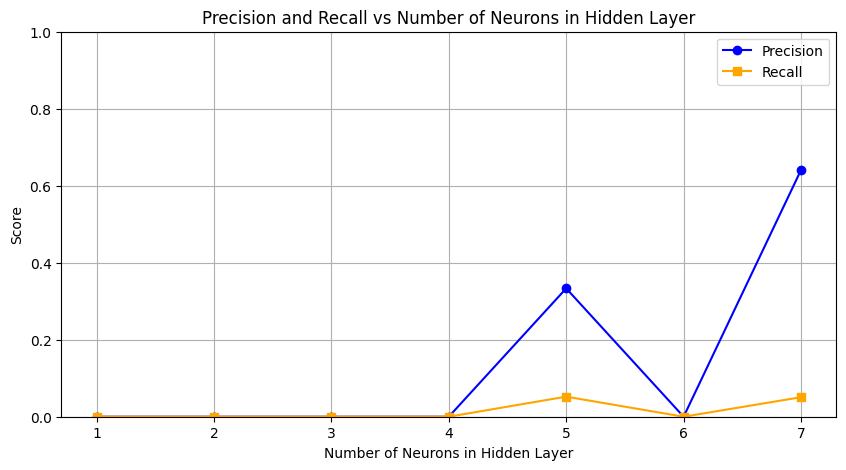

In [ ]:
# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(layer1_sizes, precisions, marker='o', label='Precision', color='blue')
plt.plot(layer1_sizes, recalls, marker='s', label='Recall', color='orange')

plt.title('Precision and Recall vs Number of Neurons in Hidden Layer')
plt.xlabel('Number of Neurons in Hidden Layer')
plt.ylabel('Score')
plt.xticks(layer1_sizes)  # Она даст метки только на заданных значениях
plt.ylim(0, 1)  # Установим пределы от 0 до 1 для лучшей визуализации
plt.legend()
plt.grid(True)
plt.show()

# Задача 2
1. **Точки внутри шара радиуса 0.5 с центром в (0, -0.5, 0)**

2. **Точки выше плоскости x + y + z = 3**

3. **Точки ниже плоскости x − y + z = −3**



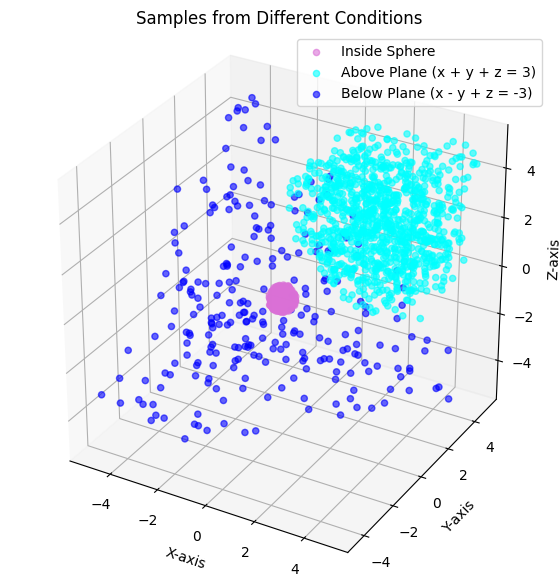

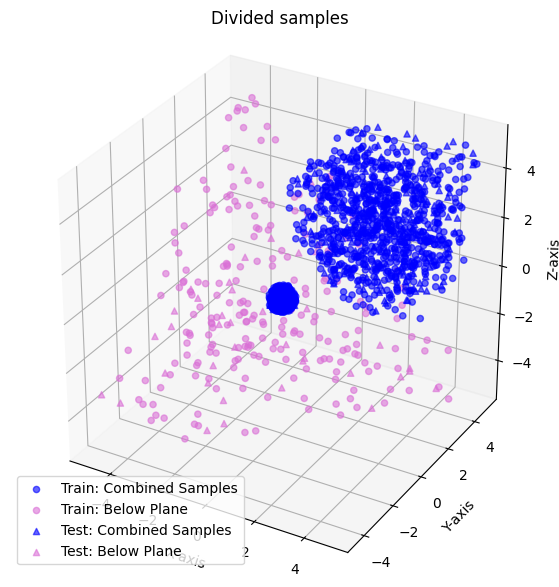

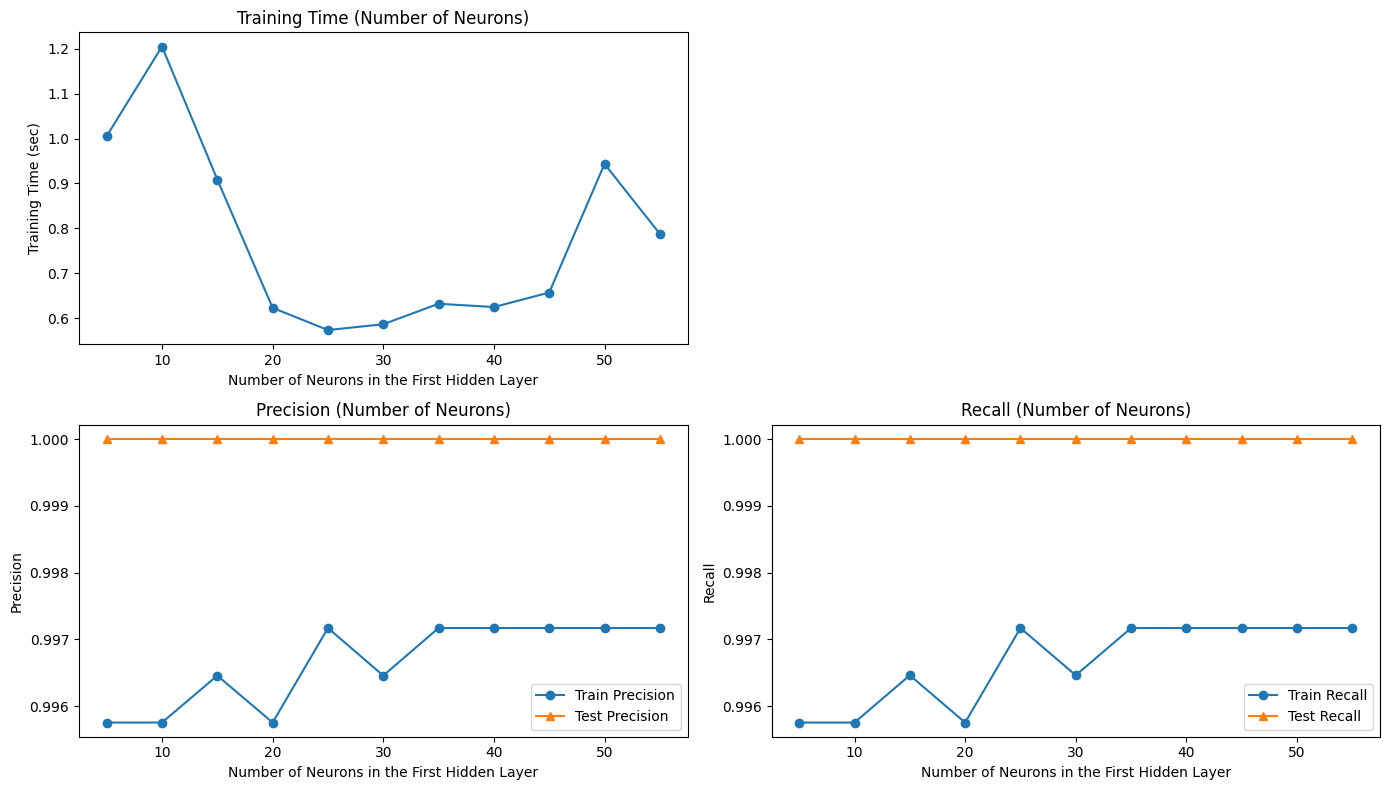

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
import time

# Создадим класс Samples
class Samples:
    def __init__(self, num_samples):

        # Генерация выборок
        self.sphere_samples = self.generate_samples_sphere(num_samples)
        self.above_plane_samples = self.generate_samples_above_plane(num_samples)
        self.below_plane_samples = self.generate_samples_below_plane(num_samples)

        # Объединение данных
        self.combined_samples = np.vstack((self.sphere_samples, self.above_plane_samples))
        self.combined_labels = np.zeros(len(self.combined_samples))  # метка 0 для объединённых выборок
        self.below_plane_labels = np.ones(len(self.below_plane_samples))  # метка 1 для ниже плоскости

        # Объединение всех данных
        self.all_samples = np.vstack((self.combined_samples, self.below_plane_samples))
        self.all_labels = np.concatenate((self.combined_labels, self.below_plane_labels))

        # Разделение на обучающие и тестовые выборки
        self.train_samples, self.test_samples, self.train_labels, self.test_labels = self.split_data()

    def generate_samples_sphere(self, num_samples):
        """Генерация точек внутри шара радиусом 0.5 с центром в (0, -0.5, 0)."""
        r = 0.5
        points = np.random.uniform(low=-r, high=r, size=(num_samples, 3))
        inside_sphere = np.sum(points**2, axis=1) < r**2
        return points[inside_sphere][:num_samples]

    def generate_samples_above_plane(self, num_samples):
        """Генерация точек выше плоскости x + y + z = 3."""
        points = np.random.uniform(low=0, high=5, size=(num_samples, 3))
        return points[points[:, 0] + points[:, 1] + points[:, 2] > 3][:num_samples]

    def generate_samples_below_plane(self, num_samples):
        """Генерация точек ниже плоскости x - y + z = -3."""
        points = np.random.uniform(low=-5, high=5, size=(num_samples, 3))
        return points[points[:, 0] - points[:, 1] + points[:, 2] < -3][:num_samples]

    def split_data(self):
        """Разделение данных на обучающую и тестовую выборки."""
        return train_test_split(self.all_samples, self.all_labels, test_size=0.2)

    def visualize_samples_on_one_plot(self):
        """Генерация и визуализация выборок на одном графике."""
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Добавление точек в график
        ax.scatter(self.sphere_samples[:, 0], self.sphere_samples[:, 1], self.sphere_samples[:, 2],
                   color='orchid', alpha=0.6, label='Inside Sphere')
        ax.scatter(self.above_plane_samples[:, 0], self.above_plane_samples[:, 1], self.above_plane_samples[:, 2],
                   color='cyan', alpha=0.6, label='Above Plane (x + y + z = 3)')
        ax.scatter(self.below_plane_samples[:, 0], self.below_plane_samples[:, 1], self.below_plane_samples[:, 2],
                   color='blue', alpha=0.6, label='Below Plane (x - y + z = -3)')

        ax.set_title('Samples from Different Conditions')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_zlabel('Z-axis')
        ax.set_box_aspect([1, 1, 1])
        ax.legend()

        plt.show()

    def visualize_test_train(self):
        """Визуализация всех тестовых и тренировочных выборок на одном графике."""
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Визуализация обучающих выборок
        ax.scatter(self.train_samples[self.train_labels == 0][:, 0],
                   self.train_samples[self.train_labels == 0][:, 1],
                   self.train_samples[self.train_labels == 0][:, 2],
                   color='blue', alpha=0.6, label='Train: Combined Samples')

        ax.scatter(self.train_samples[self.train_labels == 1][:, 0],
                   self.train_samples[self.train_labels == 1][:, 1],
                   self.train_samples[self.train_labels == 1][:, 2],
                   color='orchid', alpha=0.6, label='Train: Below Plane')

        # Визуализация тестовых выборок
        ax.scatter(self.test_samples[self.test_labels == 0][:, 0],
                   self.test_samples[self.test_labels == 0][:, 1],
                   self.test_samples[self.test_labels == 0][:, 2],
                   color='blue', marker='^', alpha=0.6, label='Test: Combined Samples')

        ax.scatter(self.test_samples[self.test_labels == 1][:, 0],
                   self.test_samples[self.test_labels == 1][:, 1],
                   self.test_samples[self.test_labels == 1][:, 2],
                   color='orchid', marker='^', alpha=0.6, label='Test: Below Plane')

        ax.set_title('Divided samples')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_zlabel('Z-axis')
        ax.set_box_aspect([1, 1, 1])
        ax.legend()

        plt.show()



# Функция для обучения MLP и сбора результатов
def train_mlp(samples, num_neurons_list):
    training_times = []
    train_precisions = []
    train_recalls = []
    test_precisions = []
    test_recalls = []

    for num_neurons in num_neurons_list:
        model = MLPClassifier(hidden_layer_sizes=(num_neurons,), max_iter=1000, random_state=42)

        # Измерение времени обучения
        start_time = time.time()
        model.fit(samples.train_samples, samples.train_labels)
        training_time = time.time() - start_time

        # Предсказания и метрики

        train_pred = model.predict(samples.train_samples)
        test_pred = model.predict(samples.test_samples)

        # Вычисление precision и recall
        train_precision = precision_score(samples.train_labels, train_pred, average='weighted')
        train_recall = recall_score(samples.train_labels, train_pred, average='weighted')
        test_precision = precision_score(samples.test_labels, test_pred, average='weighted')
        test_recall = recall_score(samples.test_labels, test_pred, average='weighted')

        # Сохранение результатов
        training_times.append(training_time)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        test_precisions.append(test_precision)
        test_recalls.append(test_recall)

    return training_times, train_precisions, train_recalls, test_precisions, test_recalls

# Создание выборок
num_samples = 1000
num_neurons_list = list(range(5, 56, 5))  # 5, 10, 15, ..., 55
samples = Samples(num_samples)

# Визуализация выборок
samples.visualize_samples_on_one_plot()
samples.visualize_test_train()

training_times, train_precisions, train_recalls, test_precisions, test_recalls = train_mlp(samples, num_neurons_list)


# Построение графиков
plt.figure(figsize=(14, 8))

# Время обучения
plt.subplot(2, 2, 1)
plt.plot(num_neurons_list, training_times, marker='o')
plt.title('Training Time (Number of Neurons)')
plt.xlabel('Number of Neurons in the First Hidden Layer')
plt.ylabel('Training Time (sec)')

# Precision для обучающей выборки
plt.subplot(2, 2, 3)
plt.plot(num_neurons_list, train_precisions, marker='o', label='Train Precision')
plt.plot(num_neurons_list, test_precisions, marker='^', label='Test Precision')
plt.title('Precision (Number of Neurons)')
plt.xlabel('Number of Neurons in the First Hidden Layer')
plt.ylabel('Precision')
plt.legend()

# Recall для обучающей выборки
plt.subplot(2, 2, 4)
plt.plot(num_neurons_list, train_recalls, marker='o', label='Train Recall')
plt.plot(num_neurons_list, test_recalls, marker='^', label='Test Recall')
plt.title('Recall (Number of Neurons)')
plt.xlabel('Number of Neurons in the First Hidden Layer')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()
